In [1]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.sparse import diags
import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import mylib

$$\frac{d}{dx}\left(m_{uu}\frac{du}{dx}\right)+\frac{d}{dx}\left(m_{uv}\frac{dv}{dx}\right)=f_1\qquad x\in\,(0,L)$$
$$~$$
$$\frac{d}{dx}\left(m_{vu}\frac{du}{dx}\right)+\frac{d}{dx}\left(m_{vv}\frac{dv}{dx}\right)=f_2\qquad x\in\,(0,L)$$

In [2]:
def fmuu(x, kwargs):
    return kwargs['A'] + kwargs['B']*np.sin(kwargs['C']*x)

def dfmuudx(x, kwargs):
    return kwargs['B']*kwargs['C']*np.cos(kwargs['C']*x)


def fmuv(x, kwargs):
    return kwargs['D'] + kwargs['E']*x

def dfmuvdx(x, kwargs):
    return kwargs['E'] + 0.0*x


def fmvu(x, kwargs):
    return -fmuv(x, kwargs)

def dfmvudx(x, kwargs):
    return -dfmuvdx(x, kwargs)


def fmvv(x, kwargs):
    return kwargs['F'] + kwargs['G']*np.sin(kwargs['H']*x)

def dfmvvdx(x, kwargs):
    return kwargs['G']*kwargs['H']*np.cos(kwargs['H']*x)


def u_sol(x, kwargs):
    return np.exp(np.sin(x))

def du_soldx(x, kwargs):
    return np.cos(x)*np.exp(np.sin(x))

def d2u_soldx2(x, kwargs):
    return -np.sin(x)*np.exp(np.sin(x)) + np.square(np.cos(x))*np.exp(np.sin(x))


def v_sol(x, kwargs):
    return - np.square(x) + x - 1.0 

def dv_soldx(x, kwargs):
    return - 2.0*x + 1.0

def d2v_soldx2(x, kwargs):
    return - 2.0 + 0.0*x


def f_1(x, kwargs):
    return dfmuudx(x, kwargs)*du_soldx(x, kwargs) + fmuu(x, kwargs)*d2u_soldx2(x, kwargs) + dfmuvdx(x, kwargs)*dv_soldx(x, kwargs) + fmuv(x, kwargs)*d2v_soldx2(x, kwargs)

def f_2(x, kwargs):
    return dfmvudx(x, kwargs)*du_soldx(x, kwargs) + fmvu(x, kwargs)*d2u_soldx2(x, kwargs) + dfmvvdx(x, kwargs)*dv_soldx(x, kwargs) + fmvv(x, kwargs)*d2v_soldx2(x, kwargs)

cond(Z) = 1258.4168694380503
monolithic error = 5.327354600427161e-13


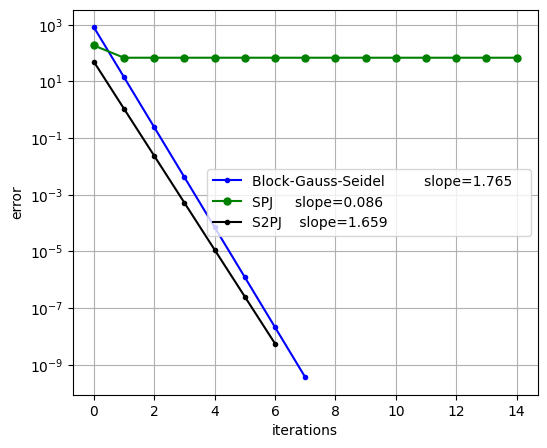

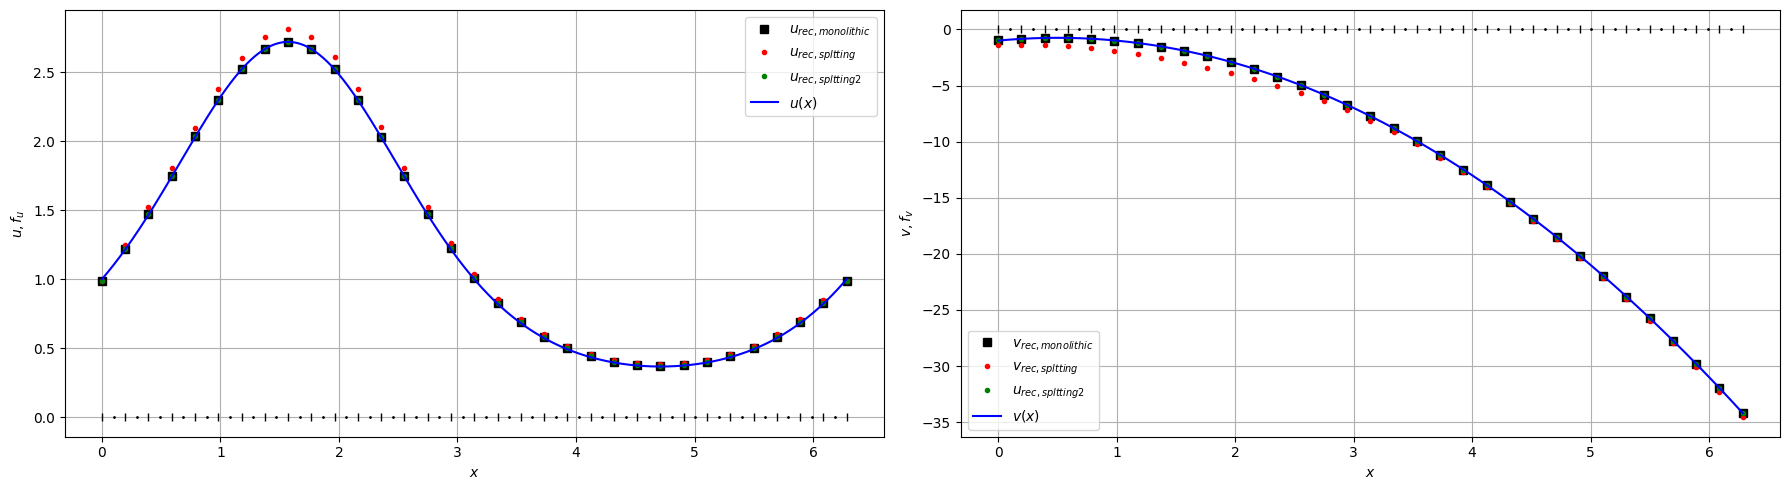

In [3]:
L = 2.0*np.pi
N = 32
dx = np.divide(L, N)
x = np.linspace(0, L, N+1)
xc = np.linspace(0.5*dx, L-0.5*dx, N)
xfine = np.linspace(0, L, 1000)
omega = 1.0
nit_max = 15
toll = 1e-8

kwargs = {
    # muu coefficients
    'A': 3.5, #const
    'B': 0.5, #amplitude
    'C': 4.0, #frequency
    
    # muv=mvu coefficients
    'D': 0.3, #const
    'E': 0.0, #slope
    
    # mvv coefficients
    'F': 1.5, #const
    'G': 0.1, #amplitude
    'H': 2.5  #frequency
}

leftBC_u = {
    'type': 'dirichlet', #'type':'neumann',
    'value': u_sol(0.0, kwargs)}

rightBC_u = {
    'type': 'dirichlet', #'type':'neumann',
    'value': u_sol(L, kwargs)}

leftBC_v = {
    'type': 'dirichlet', #'type':'neumann',
    'value': v_sol(0.0, kwargs)}

rightBC_v = {
    'type': 'dirichlet', #'type':'neumann',
    'value': v_sol(L, kwargs)}

A, fuuBC = mylib.fvm_laplacian_1D(fmuu, leftBC_u, rightBC_u, N, L, kwargs)
B, fuvBC = mylib.fvm_laplacian_1D(fmuv, leftBC_v, rightBC_v, N, L, kwargs)
C, fvuBC = mylib.fvm_laplacian_1D(fmvu, leftBC_u, rightBC_u, N, L, kwargs)
D, fvvBC = mylib.fvm_laplacian_1D(fmvv, leftBC_v, rightBC_v, N, L, kwargs)

f1 = f_1(xc, kwargs) + fuuBC + fuvBC
f2 = f_2(xc, kwargs) + fvuBC + fvvBC

Z = np.zeros((2*N,2*N))
Z[:N,:N] = A.toarray()
Z[:N,N:] = B.toarray()
Z[N:,:N] = C.toarray()
Z[N:,N:] = D.toarray()
Z = sparse.csc_matrix(Z)
f = np.concatenate((f1,f2))
sol = sparse.linalg.spsolve(Z, f)
u = sol[:N]
v = sol[N:]
u_rec = mylib.fvm_reconstruct_1D(u)
v_rec = mylib.fvm_reconstruct_1D(v)

u_BGS,  v_BGS,  res_BGS,  nit_BGS  = mylib.method_BlockGaussSeidel(     A, B, C, D, f1, f2, nit_max, toll)
u_SPJ,  v_SPJ,  res_SPJ,  nit_SPJ  = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll)
u_S2PJ, v_S2PJ, res_S2PJ, nit_S2PJ = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll)

Z = Z.toarray()
A = A.toarray()
B = B.toarray()
C = C.toarray()
D = D.toarray()

print("cond(Z) =", np.linalg.cond(Z))
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z,sol))}")

#####################################################################################################

plt.figure(dpi=100, figsize=(6,5))
nn = 5
plt.semilogy(res_BGS, 'b.-',  label=f"Block-Gauss-Seidel         slope={np.round(-mylib.slope(res_BGS[:nn]), 3)}   ")
plt.semilogy(res_SPJ, 'g.-',  label=f"SPJ     slope={np.round(-mylib.slope(res_SPJ[:nn]), 3)}", markersize=10)
plt.semilogy(res_S2PJ,'k.-',  label=f"S2PJ    slope={np.round(-mylib.slope(res_S2PJ[:nn]), 3)}")
plt.legend()
plt.grid()
plt.xlabel('iterations')
plt.ylabel('error')
# plt.savefig('figures/error2.pdf')


fig, ax = plt.subplots(1, 2, figsize=(18,5), dpi=100)
markersize = 20
linewidth = 0.8
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u,f_u$')
ax[0].plot(x, 0*x, '|', color='k', markersize=6.0)
ax[0].plot(xc, 0*xc, '.', color='k', markersize=2.0)
ax[0].plot(x, mylib.fvm_reconstruct_1D(u), 'sk' , label=r'$u_{rec,monolithic}$', linewidth=linewidth)
ax[0].plot(x, mylib.fvm_reconstruct_1D(u_SPJ), '.r' , label=r'$u_{rec,spltting}$', linewidth=linewidth)
ax[0].plot(x, mylib.fvm_reconstruct_1D(u_S2PJ), '.g' , label=r'$u_{rec,spltting2}$', linewidth=linewidth)
# ax[0].plot(xc, u, '_y', label=r'$\frac{1}{|cell|}\int u\,dx$', markersize=markersize)
ax[0].plot(xfine, u_sol(xfine, kwargs), '-b', label=r'$u(x)$')
#ax[0].plot(xfine, m_u(xfine, kwargs), '--g', label=r'$m_u(x)$')
#ax[0].plot(xfine, f_u(xfine, kwargs), '--c', label=r'$f_u(x)$')
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$v,f_v$')
ax[1].plot(x, 0*x, '|', color='k', markersize=6.0)
ax[1].plot(xc, 0*xc, '.', color='k', markersize=2.0)
ax[1].plot(x, mylib.fvm_reconstruct_1D(v), 'sk' , label=r'$v_{rec,monolithic}$', linewidth=linewidth)
ax[1].plot(x, mylib.fvm_reconstruct_1D(v_SPJ), '.r' , label=r'$v_{rec,spltting}$', linewidth=linewidth)
ax[1].plot(x, mylib.fvm_reconstruct_1D(v_S2PJ), '.g' , label=r'$u_{rec,spltting2}$', linewidth=linewidth)
# ax[1].plot(xc, v, '_y', label=r'$\frac{1}{|cell|}\int v\,dx$', markersize=markersize)
ax[1].plot(xfine, v_sol(xfine, kwargs), '-b', label=r'$v(x)$')
#ax[1].plot(xfine, m_v(xfine, kwargs), '--g', label=r'$m_v(x)$')
#ax[1].plot(xfine, f_v(xfine, kwargs), '--c', label=r'$f_v(x)$')
ax[1].legend()
ax[1].grid()

#ax[0].plot(x, mylib.fvm_reconstruct_1D(fTOT), '-g' , label='furec', linewidth=linewidth)
#ax[0].plot(xc, ff, '_g', label='ff', markersize=markersize)
#ax[0].set_ylim(bottom=-4, top=4)
#ax[1].set_ylim(bottom=-4, top=4)
#ax[0].set_xlim([-0.001,0.1])
plt.tight_layout()
plt.show()
